In [0]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import zipfile
import cv2
import tensorflow as tf
import time

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge,Lasso

from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Flatten, Dropout
from keras.optimizers import RMSprop,Adam,SGD
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras.layers import Dense, LSTM
from keras import initializers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

sns.set()

In [130]:
url='/content/energy_train.csv'
df_training = pd.read_csv(url)
df_training.head()

,id,date,WattHour,luminousity,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2
0,1,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,17.166667,55.20,7.026667,84.256667,17.200000,41.626667,18.2,48.900000,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,17.166667,55.20,6.833333,84.063333,17.200000,41.560000,18.2,48.863333,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,3,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,17.166667,55.09,6.560000,83.156667,17.200000,41.433333,18.2,48.730000,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,4,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,17.166667,55.09,6.433333,83.423333,17.133333,41.290000,18.1,48.590000,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,5,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,NaN,45.000000,18.890000,45.530000,17.200000,55.09,6.366667,84.893333,17.200000,41.230000,18.1,48.590000,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [131]:
url='/content/energy_test.csv'
df_testing = pd.read_csv(url)
df_testing.head()

,id,date,luminousity,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2
0,15001,2016-04-24 21:00:00,0,21.926667,35.5,19.2900,37.500000,22.39,34.000000,21.39,32.225714,20.5,40.79,3.466667,37.660000,21.890000,29.976000,24.390000,35.700000,20.200000,NaN,4.10,758.00,82.000000,3.0,40.0,1.2,10.668196,10.668196
1,15002,2016-04-24 21:10:00,0,21.890000,35.4,19.2225,37.425000,22.39,34.090000,21.35,32.200000,20.5,40.79,3.326667,39.526667,21.890000,30.100000,24.390000,35.730000,20.200000,32.400000,3.95,758.05,82.166667,3.0,40.0,1.1,48.467852,48.467852
2,15003,2016-04-24 21:20:00,0,21.890000,35.4,19.2000,37.466667,22.39,33.963333,21.29,32.277143,20.5,40.70,3.290000,41.533333,21.830000,30.140000,24.323333,35.863333,20.200000,32.290000,3.80,758.10,82.333333,3.0,40.0,1.0,36.388536,36.388536
3,15004,2016-04-24 21:30:00,0,21.890000,35.4,19.1000,37.590000,22.39,33.900000,21.29,32.334000,20.5,40.70,3.290000,42.533333,21.804286,30.212857,24.390000,35.933333,20.175000,32.290000,3.65,758.15,82.500000,3.0,40.0,0.9,17.198176,17.198176
4,15005,2016-04-24 21:40:00,0,21.890000,35.4,19.1000,37.590000,22.39,33.966667,21.29,32.290000,20.5,40.70,3.060000,43.396667,21.790000,30.456000,24.323333,36.133333,20.166667,32.563333,3.50,758.20,82.666667,3.0,40.0,0.8,7.200588,7.200588


In [132]:
df_training['source']='train'
df_testing['source']='test'
print(df_training.head(3))
print(df_testing.head(3))

   id                 date  ...  random_variable_2  source
0   1  2016-01-11 17:00:00  ...          13.275433   train
1   2  2016-01-11 17:10:00  ...          18.606195   train
2   3  2016-01-11 17:20:00  ...          28.642668   train

[3 rows x 31 columns]
      id                 date  ...  random_variable_2  source
0  15001  2016-04-24 21:00:00  ...          10.668196    test
1  15002  2016-04-24 21:10:00  ...          48.467852    test
2  15003  2016-04-24 21:20:00  ...          36.388536    test

[3 rows x 30 columns]


In [133]:
df = pd.concat([df_training,df_testing],axis=0,ignore_index=True)
df

,id,date,WattHour,luminousity,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2,source
0,1,2016-01-11 17:00:00,60.0,30,19.890000,47.596667,19.200000,44.790000,19.790000,44.730000,19.000000,45.566667,17.166667,55.200000,7.026667,84.256667,17.200000,41.626667,18.200000,48.900000,17.033333,45.530000,6.600000,733.500000,92.0,7.000000,63.000000,5.300000,13.275433,13.275433,train
1,2,2016-01-11 17:10:00,60.0,30,19.890000,46.693333,19.200000,44.722500,19.790000,44.790000,19.000000,45.992500,17.166667,55.200000,6.833333,84.063333,17.200000,41.560000,18.200000,48.863333,17.066667,45.560000,6.483333,733.600000,92.0,6.666667,59.166667,5.200000,18.606195,18.606195,train
2,3,2016-01-11 17:20:00,50.0,30,19.890000,46.300000,19.200000,44.626667,19.790000,44.933333,18.926667,45.890000,17.166667,55.090000,6.560000,83.156667,17.200000,41.433333,18.200000,48.730000,17.000000,45.500000,6.366667,733.700000,92.0,6.333333,55.333333,5.100000,28.642668,28.642668,train
3,4,2016-01-11 17:30:00,50.0,40,19.890000,46.066667,19.200000,44.590000,19.790000,45.000000,18.890000,45.723333,17.166667,55.090000,6.433333,83.423333,17.133333,41.290000,18.100000,48.590000,17.000000,45.400000,6.250000,733.800000,92.0,6.000000,51.500000,5.000000,45.410389,45.410389,train
4,5,2016-01-11 17:40:00,60.0,40,19.890000,46.333333,19.200000,44.530000,NaN,45.000000,18.890000,45.530000,17.200000,55.090000,6.366667,84.893333,17.200000,41.230000,18.100000,48.590000,17.000000,45.400000,6.133333,733.900000,92.0,5.666667,47.666667,4.900000,10.084097,10.084097,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19370,19371,2016-05-25 05:20:00,NaN,10,23.600000,40.833333,20.856667,43.566667,25.260000,39.266667,23.500000,39.000000,19.700000,39.081250,5.563333,41.600000,23.000000,35.090000,24.171429,43.264286,22.600000,44.790000,6.166667,757.133333,95.0,1.000000,24.666667,5.433333,43.792662,43.792662,test
19371,19372,2016-05-25 05:30:00,NaN,0,23.666667,40.566667,20.790000,43.700000,25.133333,38.666667,23.500000,38.933333,19.657143,40.410000,5.763333,42.193333,23.000000,35.090000,24.160000,43.400000,22.600000,44.760000,6.150000,757.100000,95.5,1.000000,24.500000,5.500000,22.151890,22.151890,test
19372,19373,2016-05-25 05:40:00,NaN,0,23.600000,40.093333,20.700000,43.296667,24.963333,37.833333,23.463333,38.563333,19.680000,41.094000,6.123333,43.066667,22.926667,35.090000,24.100000,43.324286,22.600000,44.760000,6.133333,757.066667,96.0,1.000000,24.333333,5.566667,5.759009,5.759009,test
19373,19374,2016-05-25 05:50:00,NaN,0,23.600000,39.426667,20.633333,42.830000,24.823333,37.566667,23.390000,38.096667,19.600000,41.108571,6.330000,43.526667,22.945000,35.045000,24.100000,43.254000,22.600000,44.700000,6.116667,757.033333,96.5,1.000000,24.166667,5.633333,13.711184,13.711184,test


In [0]:
def secSinceNoon(datTimStr):
    tt = pd.to_datetime(datTimStr).time()
    return (tt.hour * 3600 + tt.minute * 60 + tt.second)/60.0

In [0]:
df['timestamp'] = pd.to_datetime(df['date'])

In [136]:
df['timestamp']

0       2016-01-11 17:00:00
1       2016-01-11 17:10:00
2       2016-01-11 17:20:00
3       2016-01-11 17:30:00
4       2016-01-11 17:40:00
                ...        
19370   2016-05-25 05:20:00
19371   2016-05-25 05:30:00
19372   2016-05-25 05:40:00
19373   2016-05-25 05:50:00
19374   2016-05-25 06:00:00
Name: timestamp, Length: 19375, dtype: datetime64[ns]

In [137]:
df['SSM'] = df['timestamp'].apply(secSinceNoon)
df['SSM']

0        1020.0
1        1030.0
2        1040.0
3        1050.0
4        1060.0
          ...  
19370     320.0
19371     330.0
19372     340.0
19373     350.0
19374     360.0
Name: SSM, Length: 19375, dtype: float64

In [138]:
df['SSM'].value_counts()

1080.0    135
1180.0    135
260.0     135
1370.0    135
1110.0    135
         ... 
440.0     134
590.0     134
430.0     134
410.0     134
770.0     134
Name: SSM, Length: 144, dtype: int64

In [139]:
df.isnull().sum().sort_values(ascending=False)

moisture_9           4601
WattHour             4375
degree_C1            3918
degree_C3            2308
SSM                     0
moisture_3              0
moisture_5              0
degree_C5               0
moisture_4              0
degree_C4               0
moisture_2              0
moisture_6              0
degree_C2               0
moisture_1              0
luminousity             0
date                    0
degree_C6               0
degree_C7               0
timestamp               0
moisture_7              0
degree_C8               0
moisture_8              0
degree_C9               0
degree_Cout             0
Pressure                0
moisture_out            0
Wind                    0
Clarity                 0
dew_index               0
random_variable_1       0
random_variable_2       0
source                  0
id                      0
dtype: int64

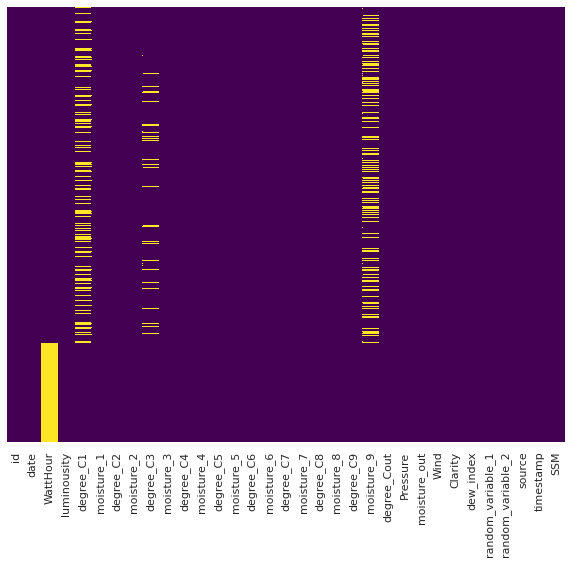

In [140]:
plt.figure(figsize=(10,8))
sns.heatmap(df.isnull(),cbar=False,yticklabels=False,cmap='viridis')
plt.show()

In [141]:
df.describe()
#luminoisity may tend to be categorical as 75%data is 0
#moisture_1 and degree_c2 are +vely skewed but shoot up in 75% - 100% value
#MISSING=> degree_c1 makes sense to fill up with mean or find a categorical mean-way as normal distributn n not much skewness
#watthour- highly +vely skewed due to also very high std
#moisture_2 is okayish but can be issue as 75% -1005 value shoots up
#MISSING=> degree_3 is also good to go with mean_values or find a categorical mean-way as normal distributn n not much skewness
#moisture_3,degree_c4,moisture_4,deg_c4,deg_c5 - good to go..normal distributn
#moisture_5 is a bit +vely skewed, but good to go as it averages out better
#degree_c6 has -ve values, and its +vely skewed b/w 75-100%
#moisture_6 is okay but min-25% gap is large
#deg_c7 is good to go- normal distrbn
#moisture_c7 is okay
#deg_c8,moisture_c8,deg_c9 is perf- normal dstrbn
#MISSING => moisture_c9 is also good to go with mean_values or find a categorical mean-way as normal distributn n not much skewness
#deg_cout has -ve values n check for skewness , mostly +vely skewed b/w 75-100%
#pressure,moisture_out - is god but might be a bit -vely skewed b/w 0-25% -> hihghly dependent asinp
#wind has 0 values , whihc may need to be given equal to min values, but distribn is okay
#clarity- 50% and 75% val is same, high std, might hv issues
#dew_index is +ve skewed b/w 75%-100% , mean is okay so mostly  okay
#random_vals1,2 have the same variable values and distrubn. need to look closely

,id,WattHour,luminousity,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2,SSM
count,19375.000000,15000.000000,19375.000000,15457.000000,19375.000000,19375.000000,19375.000000,17067.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,14774.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000,19375.000000
mean,9688.000000,98.751333,3.827097,21.774405,40.220157,20.270352,40.436162,22.286325,39.245984,20.793050,38.991712,19.553927,50.916531,7.724643,55.335967,20.205494,35.317410,21.992285,42.900976,19.430763,41.470871,7.269959,755.506795,79.879819,4.081445,38.312439,3.650808,24.995042,24.995042,715.083871
std,5593.225068,106.421877,7.959848,1.633328,3.980203,2.137612,4.071491,1.985984,3.277591,2.008673,4.361701,1.834503,9.036005,5.958490,30.890658,2.078640,5.107973,1.954581,5.240796,1.991188,4.225365,5.229336,7.466514,14.827780,2.452072,11.710588,4.143122,14.489339,14.489339,416.245244
min,1.000000,10.000000,0.000000,16.790000,27.023333,16.100000,20.463333,17.200000,28.766667,15.100000,27.660000,15.330000,29.815000,-6.065000,1.000000,15.390000,23.200000,16.306667,29.600000,14.890000,29.166667,-5.000000,729.300000,24.000000,0.000000,1.000000,-6.600000,0.005322,0.005322,0.000000
25%,4844.500000,50.000000,0.000000,20.790000,37.290000,18.790000,37.924167,20.790000,36.863333,19.500000,35.466667,18.230000,45.363333,3.560000,31.239167,18.700000,31.390000,20.760000,39.020143,18.000000,38.430000,3.583333,750.833333,70.666667,2.000000,29.000000,0.850000,12.513515,12.513515,350.000000
50%,9688.000000,60.000000,0.000000,21.700000,39.590000,19.926667,40.500000,22.100000,38.530000,20.600000,38.363333,19.326667,49.000000,7.133333,55.966667,20.000000,34.790000,22.100000,42.321429,19.356667,40.760000,6.800000,756.033333,84.000000,3.666667,40.000000,3.350000,24.909493,24.909493,720.000000
75%,14531.500000,100.000000,0.000000,22.760000,43.000000,21.390000,43.290000,23.360000,41.790000,22.000000,42.098333,20.600000,53.660000,10.963333,83.598333,21.500000,38.966667,23.290000,46.500000,20.500000,44.290000,10.266667,761.066667,91.666667,5.500000,40.000000,6.300000,37.580389,37.580389,1080.000000
max,19375.000000,1080.000000,70.000000,26.260000,63.360000,29.856667,56.026667,29.236000,50.163333,26.200000,51.090000,25.795000,96.321667,28.290000,99.900000,26.000000,51.400000,27.230000,58.780000,24.500000,53.326667,26.100000,772.300000,100.000000,14.000000,66.000000,15.500000,49.996530,49.996530,1430.000000


In [142]:
df.apply(lambda x: len(x.unique()))
#as said luminousity may be categorial

id                   19375
date                 19375
WattHour                92
luminousity              8
degree_C1              614
moisture_1            2456
degree_C2             1513
moisture_2            3176
degree_C3             1254
moisture_3            2529
degree_C4             1312
moisture_4            2898
degree_C5             2171
moisture_5            7411
degree_C6             4269
moisture_6            9578
degree_C7             1854
moisture_7            5734
degree_C8             2148
moisture_8            6539
degree_C9              908
moisture_9            3008
degree_Cout           1710
Pressure              2183
moisture_out           560
Wind                   189
Clarity                405
dew_index             1403
random_variable_1    19375
random_variable_2    19375
source                   2
timestamp            19375
SSM                    144
dtype: int64

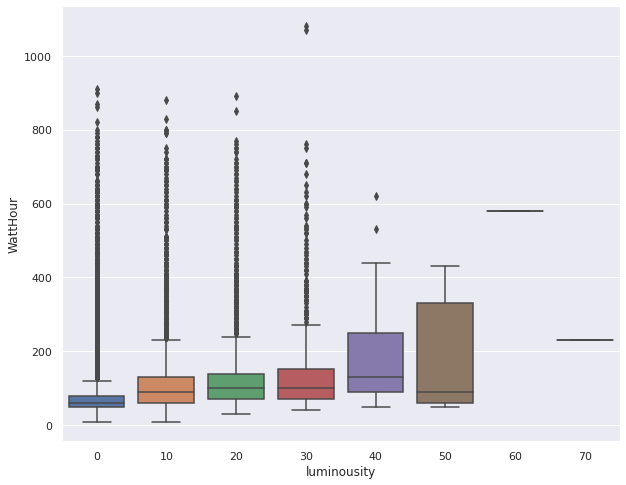

In [143]:
plt.figure(figsize=(10,8))
sns.boxplot(x=df['luminousity'],y=df['WattHour'])
plt.show()

In [144]:
corr = df.corr().round(2)
corr

,id,WattHour,luminousity,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2,SSM
id,1.00,-0.00,-0.19,0.69,-0.12,0.49,-0.09,0.79,-0.44,0.77,-0.29,0.77,-0.25,0.58,-0.82,0.83,-0.20,0.78,-0.30,0.88,-0.23,0.57,-0.03,-0.34,-0.24,-0.10,0.45,0.00,0.00,-0.00
WattHour,-0.00,1.00,0.22,0.09,0.09,0.16,-0.06,0.13,0.03,0.07,-0.00,0.03,-0.00,0.12,-0.08,0.05,-0.07,0.07,-0.12,0.03,-0.07,0.10,-0.04,-0.15,0.08,-0.01,0.02,-0.01,-0.01,0.23
luminousity,-0.19,0.22,1.00,-0.04,0.11,0.00,0.05,-0.10,0.13,-0.00,0.12,-0.08,0.14,-0.07,0.15,-0.13,0.04,-0.07,0.01,-0.16,-0.02,-0.07,-0.01,0.07,0.06,0.02,-0.03,0.00,0.00,0.26
degree_C1,0.69,0.09,-0.04,1.00,0.18,0.84,0.01,0.90,-0.00,0.88,0.11,0.89,-0.02,0.66,-0.61,0.85,0.15,0.83,0.01,0.85,0.13,0.70,-0.16,-0.35,-0.08,-0.08,0.58,-0.00,-0.00,0.17
moisture_1,-0.12,0.09,0.11,0.18,1.00,0.26,0.80,0.26,0.85,0.09,0.88,0.19,0.30,0.31,0.26,0.00,0.80,-0.04,0.73,0.10,0.77,0.33,-0.30,0.29,0.22,-0.03,0.64,0.00,0.00,0.02
degree_C2,0.49,0.16,0.00,0.84,0.26,1.00,-0.16,0.73,0.12,0.75,0.22,0.72,0.02,0.79,-0.56,0.65,0.21,0.57,0.06,0.66,0.16,0.78,-0.14,-0.51,0.09,-0.07,0.57,-0.01,-0.01,0.26
moisture_2,-0.09,-0.06,0.05,0.01,0.80,-0.16,1.00,0.15,0.68,-0.04,0.73,0.11,0.25,0.00,0.39,-0.05,0.70,-0.04,0.68,0.06,0.69,0.04,-0.26,0.59,0.07,-0.01,0.52,0.01,0.01,-0.18
degree_C3,0.79,0.13,-0.10,0.90,0.26,0.73,0.15,1.00,0.00,0.85,0.13,0.89,-0.08,0.68,-0.64,0.85,0.17,0.80,0.05,0.90,0.17,0.70,-0.21,-0.27,-0.08,-0.11,0.65,-0.00,-0.00,0.04
moisture_3,-0.44,0.03,0.13,-0.00,0.85,0.12,0.68,0.00,1.00,-0.14,0.90,-0.05,0.38,0.08,0.52,-0.26,0.84,-0.29,0.83,-0.20,0.84,0.12,-0.23,0.36,0.27,0.01,0.42,-0.00,-0.00,-0.05
degree_C4,0.77,0.07,-0.00,0.88,0.09,0.75,-0.04,0.85,-0.14,1.00,-0.07,0.87,-0.09,0.64,-0.69,0.87,0.02,0.79,-0.11,0.88,0.00,0.65,-0.08,-0.39,-0.16,-0.11,0.50,-0.00,-0.00,0.09


In [145]:
#cleaning deg_c1,deg_c3,moisture_c9

mean_deg_c1 = df.groupby('SSM').mean()['degree_C1']
mean_deg_c1


SSM
0.0       22.188079
10.0      22.126081
20.0      22.002477
30.0      22.054034
40.0      22.012346
            ...    
1390.0    22.312394
1400.0    22.218751
1410.0    22.197093
1420.0    22.134036
1430.0    22.191759
Name: degree_C1, Length: 144, dtype: float64

In [146]:
miss_bool = df['degree_C1'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
df.loc[miss_bool,'degree_C1'] = df.loc[miss_bool,'SSM'].apply(lambda x: mean_deg_c1[x])
df['degree_C1'].isnull().sum()

0

In [147]:

mean_deg_c3 = df.groupby('SSM').mean()['degree_C3']
mean_deg_c3


SSM
0.0       22.306176
10.0      22.283513
20.0      22.312552
30.0      22.356264
40.0      22.346907
            ...    
1390.0    22.403216
1400.0    22.345004
1410.0    22.313712
1420.0    22.319813
1430.0    22.303232
Name: degree_C3, Length: 144, dtype: float64

In [148]:
miss_bool = df['degree_C3'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
df.loc[miss_bool,'degree_C3'] = df.loc[miss_bool,'SSM'].apply(lambda x: mean_deg_c3[x])
df['degree_C3'].isnull().sum()

0

In [149]:

mean_moisture_9 = df.groupby('SSM').mean()['moisture_9']
mean_moisture_9

SSM
0.0       41.409378
10.0      41.603296
20.0      41.285473
30.0      41.522608
40.0      41.975621
            ...    
1390.0    40.897239
1400.0    40.805052
1410.0    41.265355
1420.0    41.265251
1430.0    41.371603
Name: moisture_9, Length: 144, dtype: float64

In [150]:
miss_bool = df['moisture_9'].isnull() 

#Impute data and check #missing values before and after imputation to confirm
df.loc[miss_bool,'moisture_9'] = df.loc[miss_bool,'SSM'].apply(lambda x: mean_moisture_9[x])
df['moisture_9'].isnull().sum()

0

In [151]:
df.isnull().sum().sort_values(ascending=False)

WattHour             4375
SSM                     0
moisture_6              0
date                    0
luminousity             0
degree_C1               0
moisture_1              0
degree_C2               0
moisture_2              0
degree_C3               0
moisture_3              0
degree_C4               0
moisture_4              0
degree_C5               0
moisture_5              0
degree_C6               0
degree_C7               0
timestamp               0
moisture_7              0
degree_C8               0
moisture_8              0
degree_C9               0
moisture_9              0
degree_Cout             0
Pressure                0
moisture_out            0
Wind                    0
Clarity                 0
dew_index               0
random_variable_1       0
random_variable_2       0
source                  0
id                      0
dtype: int64

In [152]:
min_wind_value = df[df['Wind']!=0]['Wind'].min()
min_wind_value

0.166666666666667

In [153]:
filt = df['Wind'] == 0
df.loc[filt,'Wind'] = min_wind_value
df[df['Wind']==0]

,id,date,WattHour,luminousity,degree_C1,moisture_1,degree_C2,moisture_2,degree_C3,moisture_3,degree_C4,moisture_4,degree_C5,moisture_5,degree_C6,moisture_6,degree_C7,moisture_7,degree_C8,moisture_8,degree_C9,moisture_9,degree_Cout,Pressure,moisture_out,Wind,Clarity,dew_index,random_variable_1,random_variable_2,source,timestamp,SSM


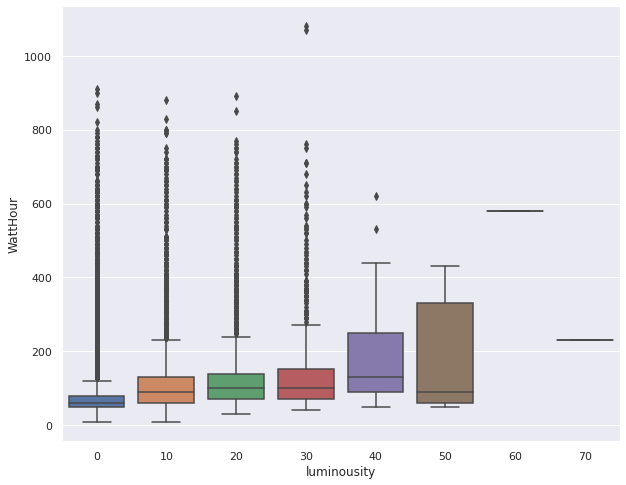

In [154]:
plt.figure(figsize=(10,8))
sns.boxplot(x=df['luminousity'],y=df['WattHour'])
plt.show()

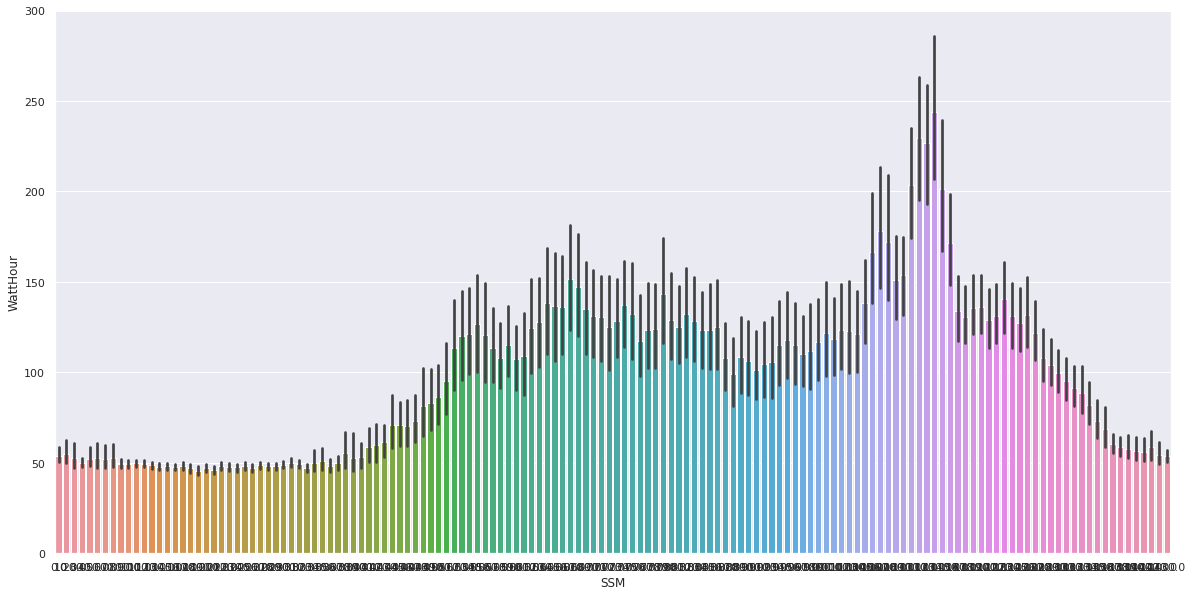

In [155]:
plt.figure(figsize=(20,10))
sns.barplot(x=df['SSM'] , y=df['WattHour'].dropna())
plt.show()

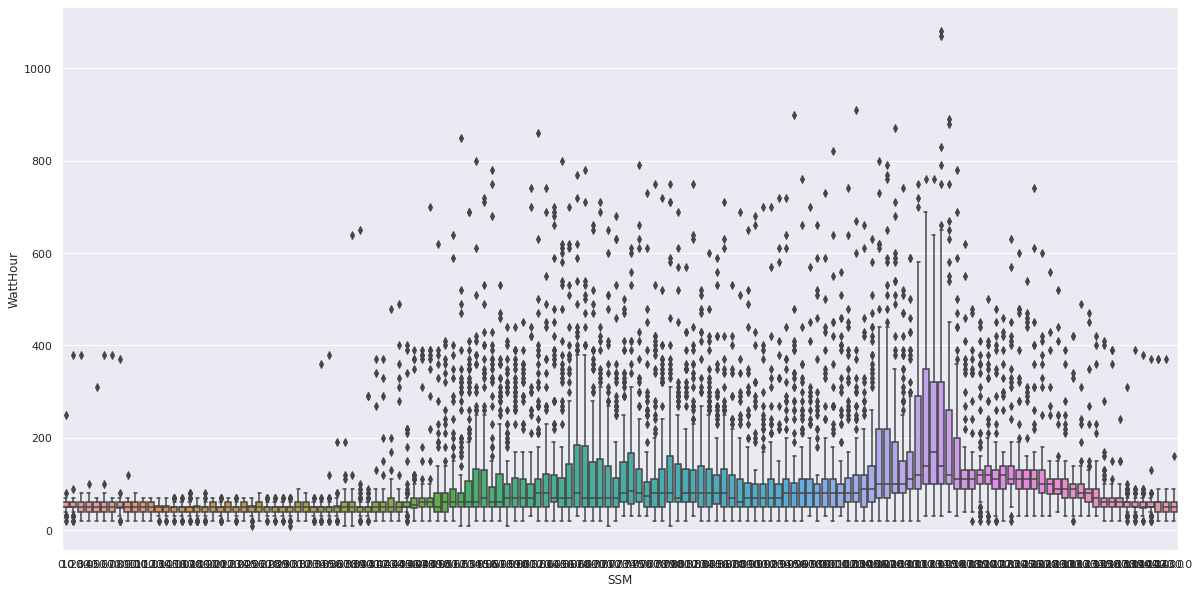

In [156]:
plt.figure(figsize=(20,10))
sns.boxplot(x=df['SSM'] , y=df['WattHour'].dropna())
plt.show()

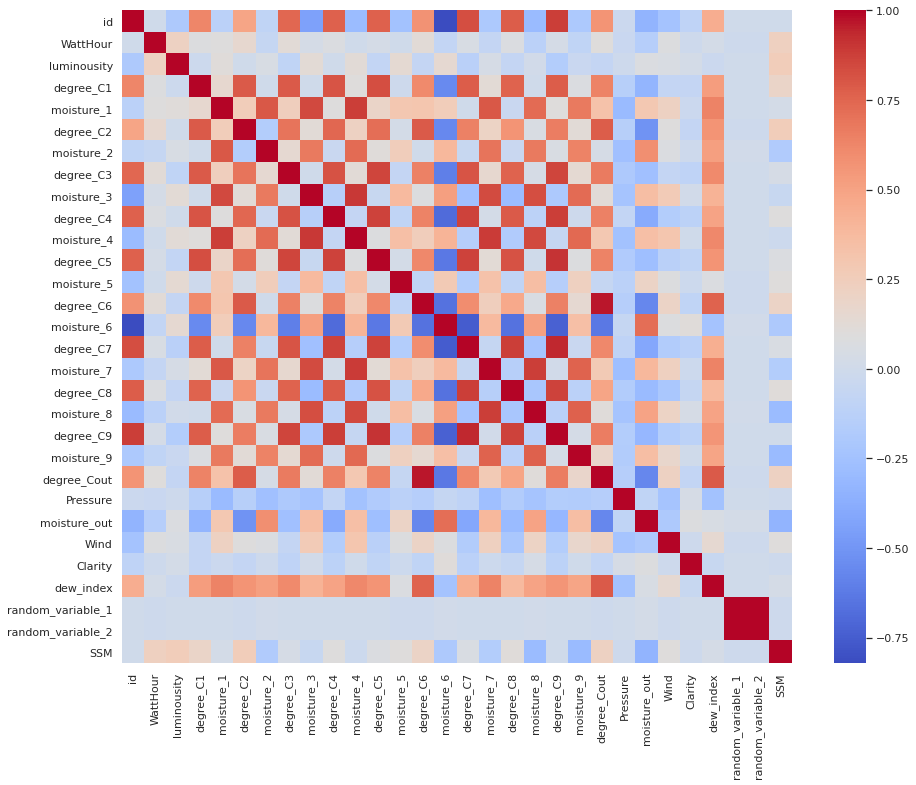

In [157]:
plt.figure(figsize=(15,12))
sns.heatmap(df.corr().round(2),cmap='coolwarm')

In [158]:
columns= ['degree_C1','degree_C2','degree_C3','degree_C4','degree_C5','degree_C6','degree_C7','degree_C8','degree_C9']

df['mean_degree'] = df.loc[:,columns].sum(axis=1)
df['mean_degree'] = df['mean_degree'] / 9.0
df['mean_degree']

0        17.167407
1        17.149630
2        17.103704
3        17.067037
4        17.368891
           ...    
19370    20.916825
19371    20.918942
19372    20.906296
19373    20.891296
19374    20.895926
Name: mean_degree, Length: 19375, dtype: float64

In [159]:
columns= ['moisture_1','moisture_2','moisture_3','moisture_4','moisture_5','moisture_6','moisture_7','moisture_8','moisture_9']

df['mean_moisture'] = df.loc[:,columns].sum(axis=1)
df['mean_moisture'] = df['mean_moisture'] / 9.0
df['mean_moisture']

0        50.910741
1        50.827222
2        50.628889
3        50.574815
4        50.732963
           ...    
19370    40.721356
19371    40.857778
19372    40.791291
19373    40.617138
19374    40.370497
Name: mean_moisture, Length: 19375, dtype: float64

In [0]:
df.drop(['random_variable_1','random_variable_2','degree_C1','moisture_1','moisture_2','degree_C3','moisture_3',
         'moisture_4','degree_C4','moisture_5','degree_C5','moisture_6','moisture_7','degree_C7','moisture_8','degree_C8'
         ,'moisture_9','degree_C9','moisture_out']
     ,axis=1,inplace=True)

In [0]:
df.drop(['date','timestamp','id'],axis=1,inplace=True)

In [162]:
df

,WattHour,luminousity,degree_C2,degree_C6,degree_Cout,Pressure,Wind,Clarity,dew_index,source,SSM,mean_degree,mean_moisture
0,60.0,30,19.200000,7.026667,6.600000,733.500000,7.000000,63.000000,5.300000,train,1020.0,17.167407,50.910741
1,60.0,30,19.200000,6.833333,6.483333,733.600000,6.666667,59.166667,5.200000,train,1030.0,17.149630,50.827222
2,50.0,30,19.200000,6.560000,6.366667,733.700000,6.333333,55.333333,5.100000,train,1040.0,17.103704,50.628889
3,50.0,40,19.200000,6.433333,6.250000,733.800000,6.000000,51.500000,5.000000,train,1050.0,17.067037,50.574815
4,60.0,40,19.200000,6.366667,6.133333,733.900000,5.666667,47.666667,4.900000,train,1060.0,17.368891,50.732963
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19370,NaN,10,20.856667,5.563333,6.166667,757.133333,1.000000,24.666667,5.433333,test,320.0,20.916825,40.721356
19371,NaN,0,20.790000,5.763333,6.150000,757.100000,1.000000,24.500000,5.500000,test,330.0,20.918942,40.857778
19372,NaN,0,20.700000,6.123333,6.133333,757.066667,1.000000,24.333333,5.566667,test,340.0,20.906296,40.791291
19373,NaN,0,20.633333,6.330000,6.116667,757.033333,1.000000,24.166667,5.633333,test,350.0,20.891296,40.617138


In [0]:
train = df.loc[df['source']=='train']
test = df.loc[df['source']=='test']

In [164]:
train.head()

,WattHour,luminousity,degree_C2,degree_C6,degree_Cout,Pressure,Wind,Clarity,dew_index,source,SSM,mean_degree,mean_moisture
0,60.0,30,19.2,7.026667,6.600000,733.5,7.000000,63.000000,5.3,train,1020.0,17.167407,50.910741
1,60.0,30,19.2,6.833333,6.483333,733.6,6.666667,59.166667,5.2,train,1030.0,17.149630,50.827222
2,50.0,30,19.2,6.560000,6.366667,733.7,6.333333,55.333333,5.1,train,1040.0,17.103704,50.628889
3,50.0,40,19.2,6.433333,6.250000,733.8,6.000000,51.500000,5.0,train,1050.0,17.067037,50.574815
4,60.0,40,19.2,6.366667,6.133333,733.9,5.666667,47.666667,4.9,train,1060.0,17.368891,50.732963


In [165]:
test.head()

,WattHour,luminousity,degree_C2,degree_C6,degree_Cout,Pressure,Wind,Clarity,dew_index,source,SSM,mean_degree,mean_moisture
15000,NaN,0,19.2900,3.466667,4.10,758.00,3.0,40.0,1.2,test,1260.0,19.493704,35.852825
15001,NaN,0,19.2225,3.326667,3.95,758.05,3.0,40.0,1.1,test,1270.0,19.462130,35.295741
15002,NaN,0,19.2000,3.290000,3.80,758.10,3.0,40.0,1.0,test,1280.0,19.434815,35.514868
15003,NaN,0,19.1000,3.290000,3.65,758.15,3.0,40.0,0.9,test,1290.0,19.425476,35.654836
15004,NaN,0,19.1000,3.060000,3.50,758.20,3.0,40.0,0.8,test,1300.0,19.390000,35.832889


In [0]:
train.to_csv('train_modified_final.csv', index=False)
test.to_csv('test_modified_final.csv', index=False)

In [0]:
df_train = pd.read_csv("/content/train_modified_final.csv")
df_test = pd.read_csv("/content/test_modified_final.csv")

In [168]:
df_train

,WattHour,luminousity,degree_C2,degree_C6,degree_Cout,Pressure,Wind,Clarity,dew_index,source,SSM,mean_degree,mean_moisture
0,60.0,30,19.200000,7.026667,6.600000,733.500000,7.000000,63.000000,5.3,train,1020.0,17.167407,50.910741
1,60.0,30,19.200000,6.833333,6.483333,733.600000,6.666667,59.166667,5.2,train,1030.0,17.149630,50.827222
2,50.0,30,19.200000,6.560000,6.366667,733.700000,6.333333,55.333333,5.1,train,1040.0,17.103704,50.628889
3,50.0,40,19.200000,6.433333,6.250000,733.800000,6.000000,51.500000,5.0,train,1050.0,17.067037,50.574815
4,60.0,40,19.200000,6.366667,6.133333,733.900000,5.666667,47.666667,4.9,train,1060.0,17.368891,50.732963
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,110.0,0,19.533333,4.656667,5.100000,757.833333,4.666667,40.000000,0.7,train,1210.0,19.701852,34.415999
14996,110.0,10,19.500000,4.560000,4.900000,757.866667,4.333333,40.000000,0.8,train,1220.0,19.676138,34.428603
14997,110.0,0,19.426667,4.226667,4.700000,757.900000,4.000000,40.000000,0.9,train,1230.0,19.672067,34.533016
14998,110.0,0,19.356667,3.833333,4.500000,757.933333,3.666667,40.000000,1.0,train,1240.0,19.627371,34.789608


In [169]:
df_test

,WattHour,luminousity,degree_C2,degree_C6,degree_Cout,Pressure,Wind,Clarity,dew_index,source,SSM,mean_degree,mean_moisture
0,NaN,0,19.290000,3.466667,4.100000,758.000000,3.0,40.000000,1.200000,test,1260.0,19.493704,35.852825
1,NaN,0,19.222500,3.326667,3.950000,758.050000,3.0,40.000000,1.100000,test,1270.0,19.462130,35.295741
2,NaN,0,19.200000,3.290000,3.800000,758.100000,3.0,40.000000,1.000000,test,1280.0,19.434815,35.514868
3,NaN,0,19.100000,3.290000,3.650000,758.150000,3.0,40.000000,0.900000,test,1290.0,19.425476,35.654836
4,NaN,0,19.100000,3.060000,3.500000,758.200000,3.0,40.000000,0.800000,test,1300.0,19.390000,35.832889
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4370,NaN,10,20.856667,5.563333,6.166667,757.133333,1.0,24.666667,5.433333,test,320.0,20.916825,40.721356
4371,NaN,0,20.790000,5.763333,6.150000,757.100000,1.0,24.500000,5.500000,test,330.0,20.918942,40.857778
4372,NaN,0,20.700000,6.123333,6.133333,757.066667,1.0,24.333333,5.566667,test,340.0,20.906296,40.791291
4373,NaN,0,20.633333,6.330000,6.116667,757.033333,1.0,24.166667,5.633333,test,350.0,20.891296,40.617138


In [0]:
df_test = df_test.drop(["WattHour", "source"], axis = 1)
df_train = df_train.drop(["source"], axis = 1)

In [0]:
Y_train = df_train.loc[:, "WattHour"]
df_train = df_train.drop(["WattHour"], axis = 1)

In [172]:
df_train

,luminousity,degree_C2,degree_C6,degree_Cout,Pressure,Wind,Clarity,dew_index,SSM,mean_degree,mean_moisture
0,30,19.200000,7.026667,6.600000,733.500000,7.000000,63.000000,5.3,1020.0,17.167407,50.910741
1,30,19.200000,6.833333,6.483333,733.600000,6.666667,59.166667,5.2,1030.0,17.149630,50.827222
2,30,19.200000,6.560000,6.366667,733.700000,6.333333,55.333333,5.1,1040.0,17.103704,50.628889
3,40,19.200000,6.433333,6.250000,733.800000,6.000000,51.500000,5.0,1050.0,17.067037,50.574815
4,40,19.200000,6.366667,6.133333,733.900000,5.666667,47.666667,4.9,1060.0,17.368891,50.732963
...,...,...,...,...,...,...,...,...,...,...,...
14995,0,19.533333,4.656667,5.100000,757.833333,4.666667,40.000000,0.7,1210.0,19.701852,34.415999
14996,10,19.500000,4.560000,4.900000,757.866667,4.333333,40.000000,0.8,1220.0,19.676138,34.428603
14997,0,19.426667,4.226667,4.700000,757.900000,4.000000,40.000000,0.9,1230.0,19.672067,34.533016
14998,0,19.356667,3.833333,4.500000,757.933333,3.666667,40.000000,1.0,1240.0,19.627371,34.789608


In [173]:
Y_train

0         60.0
1         60.0
2         50.0
3         50.0
4         60.0
         ...  
14995    110.0
14996    110.0
14997    110.0
14998    110.0
14999    100.0
Name: WattHour, Length: 15000, dtype: float64

In [174]:
df_test

,luminousity,degree_C2,degree_C6,degree_Cout,Pressure,Wind,Clarity,dew_index,SSM,mean_degree,mean_moisture
0,0,19.290000,3.466667,4.100000,758.000000,3.0,40.000000,1.200000,1260.0,19.493704,35.852825
1,0,19.222500,3.326667,3.950000,758.050000,3.0,40.000000,1.100000,1270.0,19.462130,35.295741
2,0,19.200000,3.290000,3.800000,758.100000,3.0,40.000000,1.000000,1280.0,19.434815,35.514868
3,0,19.100000,3.290000,3.650000,758.150000,3.0,40.000000,0.900000,1290.0,19.425476,35.654836
4,0,19.100000,3.060000,3.500000,758.200000,3.0,40.000000,0.800000,1300.0,19.390000,35.832889
...,...,...,...,...,...,...,...,...,...,...,...
4370,10,20.856667,5.563333,6.166667,757.133333,1.0,24.666667,5.433333,320.0,20.916825,40.721356
4371,0,20.790000,5.763333,6.150000,757.100000,1.0,24.500000,5.500000,330.0,20.918942,40.857778
4372,0,20.700000,6.123333,6.133333,757.066667,1.0,24.333333,5.566667,340.0,20.906296,40.791291
4373,0,20.633333,6.330000,6.116667,757.033333,1.0,24.166667,5.633333,350.0,20.891296,40.617138


In [0]:
df_train = tf.keras.utils.normalize(df_train)
df_test = tf.keras.utils.normalize(df_test)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(df_train, Y_train, test_size = 0.2)

In [0]:
X_train = X_train.to_numpy()

In [0]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [0]:
def build_regressor():
    regressor = Sequential()
    regressor.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1), kernel_initializer = 'glorot_uniform', activation = 'linear'))
    regressor.add(LSTM(units = 100, kernel_initializer = 'glorot_uniform', return_sequences = True, activation = 'linear'))
    regressor.add(LSTM(units = 100, kernel_initializer = 'glorot_uniform', activation = 'linear'))
    regressor.add(Dense(units = 128, kernel_initializer = 'glorot_uniform', activation = 'linear'))
    regressor.add(Dense(units = 1, activation = 'linear'))
    regressor.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
    return regressor

In [180]:
regressor = build_regressor()

regressor.fit(X_train, y_train, batch_size = 32, epochs = 20)

Epoch 1/20
12000/12000 [==============================] - 34s 3ms/step - loss: 11727.6950 - accuracy: 0.0039
Epoch 2/20
12000/12000 [==============================] - 31s 3ms/step - loss: 11026.4275 - accuracy: 0.0032
Epoch 3/20
12000/12000 [==============================] - 31s 3ms/step - loss: 10356.1824 - accuracy: 0.0098
Epoch 4/20
12000/12000 [==============================] - 32s 3ms/step - loss: 10157.6178 - accuracy: 0.0138
Epoch 5/20
12000/12000 [==============================] - 32s 3ms/step - loss: 10165.0094 - accuracy: 0.0100
Epoch 6/20
12000/12000 [==============================] - 32s 3ms/step - loss: 10065.2484 - accuracy: 0.0129
Epoch 7/20
12000/12000 [==============================] - 31s 3ms/step - loss: 10028.4047 - accuracy: 0.0147
Epoch 8/20
12000/12000 [==============================] - 32s 3ms/step - loss: 10016.8863 - accuracy: 0.0145
Epoch 9/20
12000/12000 [==============================] - 32s 3ms/step - loss: 9994.8569 - accuracy: 0.0128
Epoch 10/20
12000/12

In [0]:
X_test = X_test.to_numpy()

In [0]:
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [183]:
y_pred = regressor.predict(X_test)
y_pred

array([[118.16724 ],
       [ 48.828987],
       [107.088875],
       ...,
       [ 46.27411 ],
       [ 91.38437 ],
       [107.292786]], dtype=float32)

In [0]:
df_test = df_test.to_numpy()
df_test = np.reshape(df_test, (df_test.shape[0], df_test.shape[1], 1))

In [185]:
actual_pred = regressor.predict(df_test)
actual_pred

array([[96.40109 ],
       [93.41948 ],
       [90.71078 ],
       ...,
       [48.5147  ],
       [49.030148],
       [49.757843]], dtype=float32)

In [186]:
actual_pred = np.ceil(actual_pred / 10.95) * 10
actual_pred

array([[90.],
       [90.],
       [90.],
       ...,
       [50.],
       [50.],
       [50.]], dtype=float32)

In [187]:
actual_pred = actual_pred[:, 0].astype('int32')
actual_pred

array([90, 90, 90, ..., 50, 50, 50], dtype=int32)

In [188]:
ID = pd.read_csv("/content/sample_submission.csv").iloc[:, 0].values
ID

array([15001, 15002, 15003, ..., 19373, 19374, 19375])

In [189]:
df_final = pd.DataFrame({'id': ID, 'WattHour': actual_pred})
df_final

,id,WattHour
0,15001,90
1,15002,90
2,15003,90
3,15004,90
4,15005,80
...,...,...
4370,19371,50
4371,19372,50
4372,19373,50
4373,19374,50


In [0]:
#df_final.to_csv('submission_lstm_11.csv', index=False)

In [0]:
#from google.colab import files
#files.download("submission_lstm_11.csv")